In [15]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [16]:
data

,sent_id,text,label
6251,105949-03-04,monty python benny hill tekstlinjer kjole lagd...,2
3662,601343-07-01,personlig form selbekk skrevet veloverveid for...,2
819,002618-05-04,beste konge sødmefylt allsanglyrikk tenk entus...,2
1603,002800-03-03,uansett tvil trioen spennende bandene scenen,2
4889,703462-06-01,igjen fengsler cleeves fortelling faktisk litt...,2
...,...,...,...
9169,500236-06-03,stedet får film ser datiden nåtidens øyne uveg...,0
882,101014-01-02,tullmannens læregutt,0
2860,001478-05-03,fyller slett store kongescenen tilstedeværelse,0
1478,700726-09-01,sted midtveis dokumentaren faller temperaturen,0


In [17]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 15420


<AxesSubplot:>

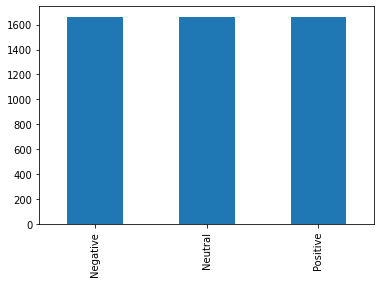

In [18]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

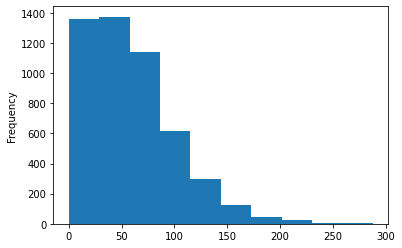

In [19]:
data["text"].str.len().plot.hist()

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data["text"])
sequences = tokenizer.texts_to_sequences(data["text"])

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

maxlen = 100
padded_data = pad_sequences(sequences, maxlen=maxlen)

Found 15419 unique tokens.


In [21]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
labels = encoder.fit_transform(data["label"])
labels = to_categorical(labels, 3)

X_train, X_val, y_train, y_val = train_test_split(padded_data, labels, test_size=0.2, random_state=42)

In [22]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3991, 100) (3991, 3)
(998, 100) (998, 3)


In [9]:
from backend.src.utils.embeddings import load_embeddings

embeddings_index = load_embeddings()

Loading embeddings: 100%|██████████| 4031461/4031461 [03:47<00:00, 17694.51it/s]


In [23]:
import numpy as np

vocab_size = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
from keras import Input
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Input(shape=(embedding_dim,), dtype="float32", name="review_input"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(3, activation="softmax"))

In [25]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1542000   
                                                                 
 review_input (InputLayer)   multiple                  0         
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               1000100   
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,545,431
Trainable params: 1,003,431
No

In [26]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 50
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
250/250 [==============================] - 4s 14ms/step - loss: 1.0237 - accuracy: 0.4798 - val_loss: 0.9658 - val_accuracy: 0.5321
Epoch 2/50
250/250 [==============================] - 2s 10ms/step - loss: 0.7847 - accuracy: 0.6535 - val_loss: 1.0215 - val_accuracy: 0.5040
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 0.5813 - accuracy: 0.7650 - val_loss: 1.1450 - val_accuracy: 0.4990
Epoch 4/50
250/250 [==============================] - 2s 8ms/step - loss: 0.3841 - accuracy: 0.8564 - val_loss: 1.3714 - val_accuracy: 0.5070


In [27]:
from datetime import datetime

model.save(f"models/SA-GLOVE-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

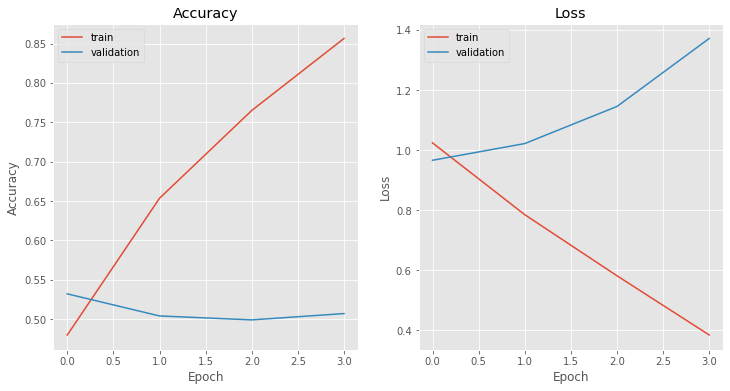

In [28]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [29]:
# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

32/32 [==============================] - 0s 5ms/step - loss: 1.3714 - accuracy: 0.5070
Validation loss: 1.371410846710205
Validation accuracy: 0.5070140361785889
